# Using the TFA toolbox

   Imports:

In [1]:
import datetime as dt
import swarmpal.toolboxes.tfa.tfa_processor as tfa

Provide values for the parameters of the analysis.  The `dataset` can be chosen from one of the compatible magnetic data collections, and the `var` is a VirES-compatible variable string (see [viresclient](https://viresclient.readthedocs.io/en/latest/available_parameters.html) for more information). The "start" and "end" times must be given as a datetime object. If the data are required as they are, set the `remove_chaos_model` parameter to False. Otherwise, if the inputs are magnetic field data and the analysis requires subtraction of the model field, set the parameter to True. 

In [2]:
dataset = "SW_OPER_MAGA_LR_1B"
var = 'B_NEC'
remove_chaos_model = True
time_start = dt.datetime(2015, 3, 14)
time_end = dt.datetime(2015, 3, 14, 23, 59, 59)

Now run the TfaInput to retrieve the selected data.

In [3]:
inputs = tfa.TfaInput(collection = dataset, 
                start_time = time_start, end_time = time_end,
                initialise = True,
                varname=var, sampling_time = "PT1S",
                remove_chaos=remove_chaos_model)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (11.455MB)

We can now use the full arsenal of functions to perform pre-processing of the data.

In [4]:
inputs.flag_cleaning()
inputs.subtract_chaos()
inputs.convert_to_mfa()
# inputs.calculate_magnitude()

Now that the model field has been removed and the transformation to Mean Field Aligned coordinate system has been performed, we can select one of the components for Wavelet processing, e.g. the compressional, by initiating the `TfaProcessor` object and specifying the name of the variable and the component number (0, 1, or 2). For MFA, 0 is the poloidal component, 1 the toroidal and 2 the compressional. Similarly for B_NEC, the numbers correspond to the North (0), East (1) or Center (2) components.

In [5]:
processor = tfa.TfaProcessor(inputs, active_variable={"varname": "B_MFA", "component": 2})

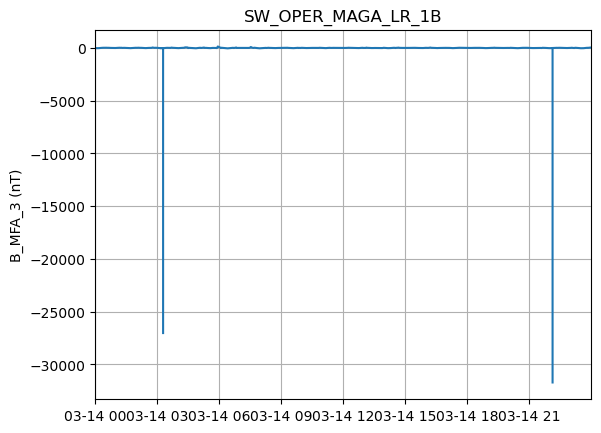

In [6]:
processor.plotX()

To perform cleaning on the data, we initialize a `Cleaning` object with the parameters of our choice and then apply it on the data with the `TfaProcessor` `apply()` function.
The active variable series can be plotted by means of the `plotX()` function.

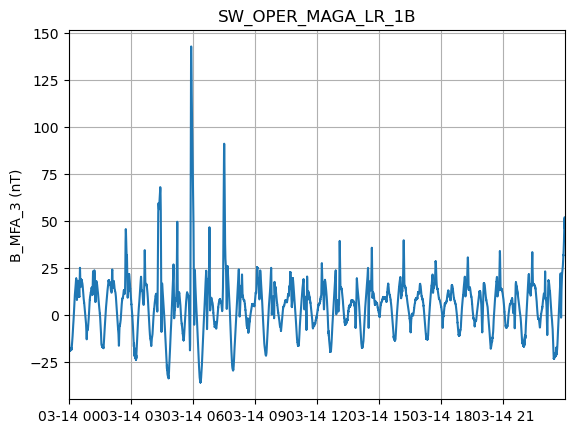

In [7]:
c = tfa.Cleaning({"Window_Size": 300, "Method": "iqr", "Multiplier": 1})
processor.apply(c)
processor.plotX()

Similarly, the filtering can be performed by first initializing a `Filtering` object with the parameters of our choosing and the applying in on the data.

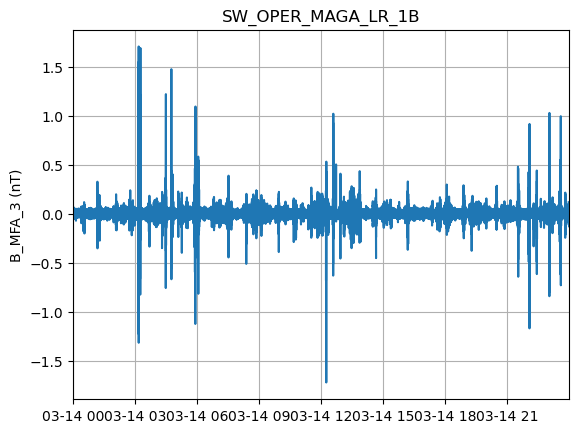

In [8]:
f = tfa.Filtering({"Sampling_Rate": 1/processor.input_data.SAMPLING_TIME, "Cutoff": 20 / 1000})
processor.apply(f)
processor.plotX()

In the same way, the wavelet transform is applied. The result of the wavelet can be visualized by means of the image() function

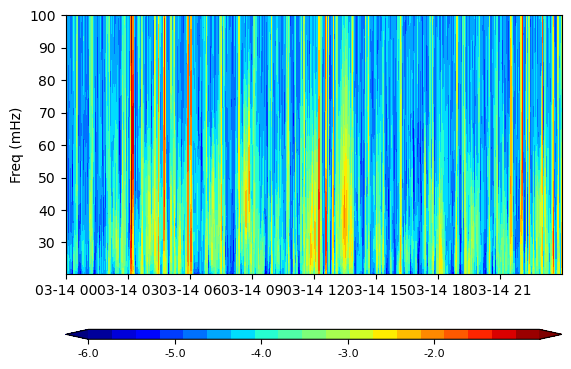

In [9]:
w = tfa.Wavelet({'Time_Step': processor.input_data.SAMPLING_TIME, 'Min_Scale': 1000/100, 'Max_Scale': 1000/20, 'dj': 0.1})
processor.apply(w)
processor.image()

This is not very useful for large time intervals e.g. an entire day, so the signal can be cut-down into segments, based on the magnetic latitude of the satellite. By default the segments correspond to tracks (half-orbits) from -75 to +75 degrees in Mag. Lat.

In [10]:
processor.create_segment_index()

All the plotting functions can now be used to visualize a specific segment.

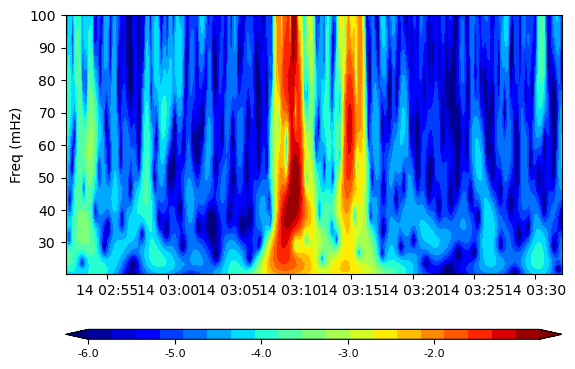

In [11]:
processor.image(segment=4)

Additional positional information (Magnetic Latitude and MLT) can also be plotted (again either for the entire series or for a specific segment)

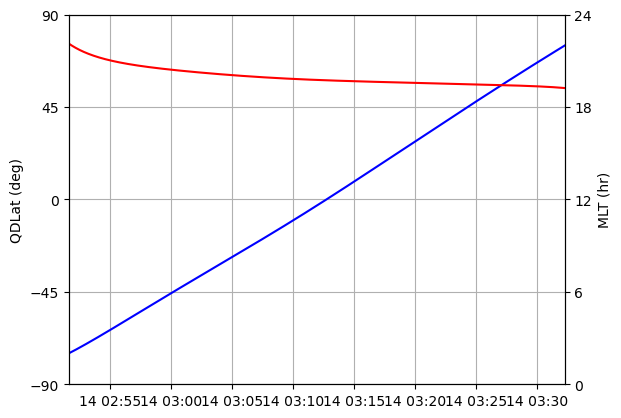

In [12]:
processor.plotAUX(segment=4)

A simple for loop can be written to produce plots for all segments and save them locally.

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["figure.max_open_warning"] = 100

for i in range(int(processor.Max_Segment)+1):
    fig, ax = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1,1.5,1]})
    plt.subplot(3,1,1)
    processor.plotX(segment=i)
    plt.subplot(3,1,2)
    processor.image(segment=i, cbar_lims=[-3, 3])
    plt.subplot(3,1,3)
    processor.plotAUX(segment=i)
    
    plt.savefig("segment_%02d.png"%i)
    plt.close(fig)